# Data scientist technical challenge


## Hipótesis: Introducción y desarrollo

Se ha pedido construir una solución basada en Machine Learning para predecir si una transacción es fraudulenta o no en base a un conjunto de datos proveniente del sistema de prevención de fraude de MercadoLibre.

Para esto, primero se realizará un análisis exploratorio de datos (EDA), en el cuál se contemplará si es necesario hacerle cambios al dataset para luego poder entrenar los modelos de forma óptima.

Después, se entrenarán dos algoritmos de aprendizaje supervisado para la tarea planteada: Random Forest y XGBoost.
Una vez los modelos estén entrenados se evaluarán y finalmente se sacará una conclusión.


## Análisis y transformaciones del dataset

In [1]:
# Importar librerías:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Vistazo de los datos

In [2]:
df = pd.read_excel('MercadoLibre Inc. Data Scientist Hiring Test - Fraud Dataset  - Data 2026.xlsx')
df.head()

# Podemos ver un dataset que tiene 21 columnas, las cuales tienen nombres encriptados salvo "Monto" y "Fecha". 
# Además de eso, vemos que la mayoría de las columnas son numéricas.

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
0,0,10,50257.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.0,0.0,7.25,37.51,1
1,0,10,29014.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,3,0.0,0.0,11.66,8.18,1
2,0,7,92.0,0,1,0.0,0.0,0,1,UY,...,0,3,1,0,2,0.0,0.0,86.97,13.96,1
3,9,16,50269.0,0,0,0.0,0.0,0,0,UY,...,0,3,1,0,5,0.0,0.0,2.51,93.67,1
4,0,8,8180.0,0,0,0.0,0.0,0,0,UY,...,0,1,1,0,1,0.0,0.0,25.96,135.40,1


In [3]:
df.info()

# También podemos ver que hay 16880 registros. Además, la mayoría de las columnas son tipo int o float, el resto (J) es object. 

# Una aclaración acá: en Excel le cambié el formato a las columnas Q, R y S a numérico, 
# porque tenían valores float pero los tomaba como texto (object).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       16880 non-null  int64  
 1   B       16880 non-null  int64  
 2   C       13683 non-null  float64
 3   D       16880 non-null  int64  
 4   E       16880 non-null  int64  
 5   F       16880 non-null  float64
 6   G       16880 non-null  float64
 7   H       16880 non-null  int64  
 8   I       16880 non-null  int64  
 9   J       16880 non-null  object 
 10  K       4016 non-null   float64
 11  L       16880 non-null  int64  
 12  M       16880 non-null  int64  
 13  N       16880 non-null  int64  
 14  O       16880 non-null  int64  
 15  P       16880 non-null  int64  
 16  Q       16880 non-null  float64
 17  R       16880 non-null  float64
 18  S       16880 non-null  float64
 19  Monto   16880 non-null  float64
 20  Fraude  16880 non-null  int64  
dtypes: float64(8), int64(12), object(1)

Análisis de nulos

In [4]:
df.isnull().sum()

# Vemos por un lado que las columnas C y K tienen nulos. 
# Y por otro lado que las columnas Q, R y S son tipo Object y deberían ser float.

A             0
B             0
C          3197
D             0
E             0
F             0
G             0
H             0
I             0
J             0
K         12864
L             0
M             0
N             0
O             0
P             0
Q             0
R             0
S             0
Monto         0
Fraude        0
dtype: int64

Valores nulos de la Columna 'C'


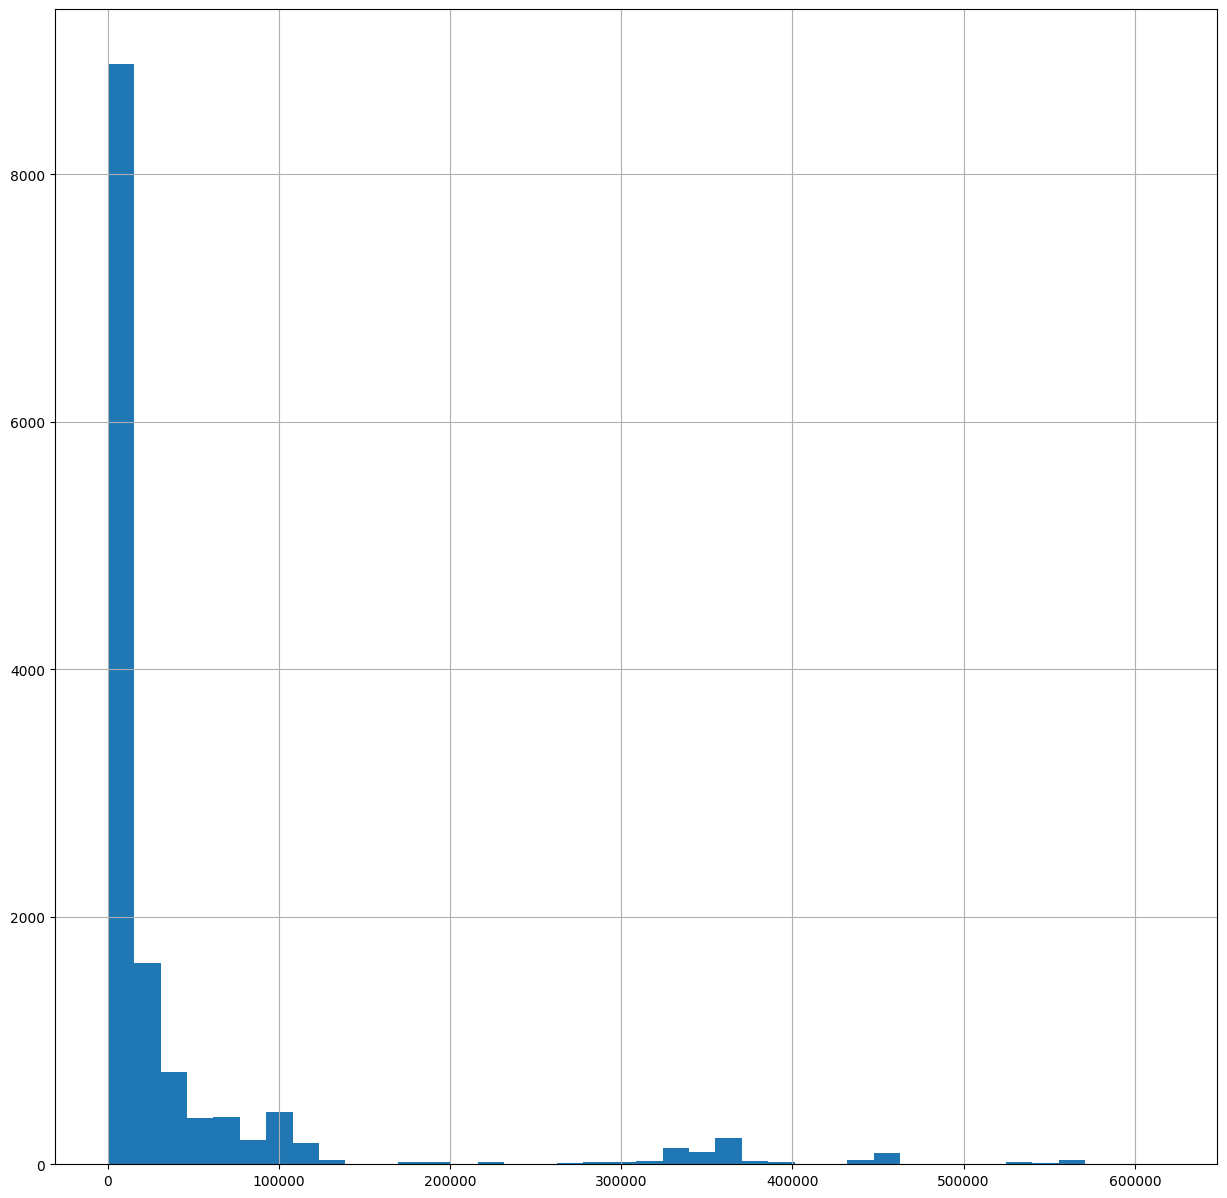

In [5]:
df['C'].hist(bins=40, figsize= (15, 15))
plt.show()

In [6]:
df['C'].median()

# Como la distribución de los valores es sesgada, podríamos reemplazar los valores nulos por la mediana, 6173.

np.float64(6173.0)

In [7]:
df["C"] = df["C"].fillna(df["C"].median())

Valores nulos de la Columna 'K'

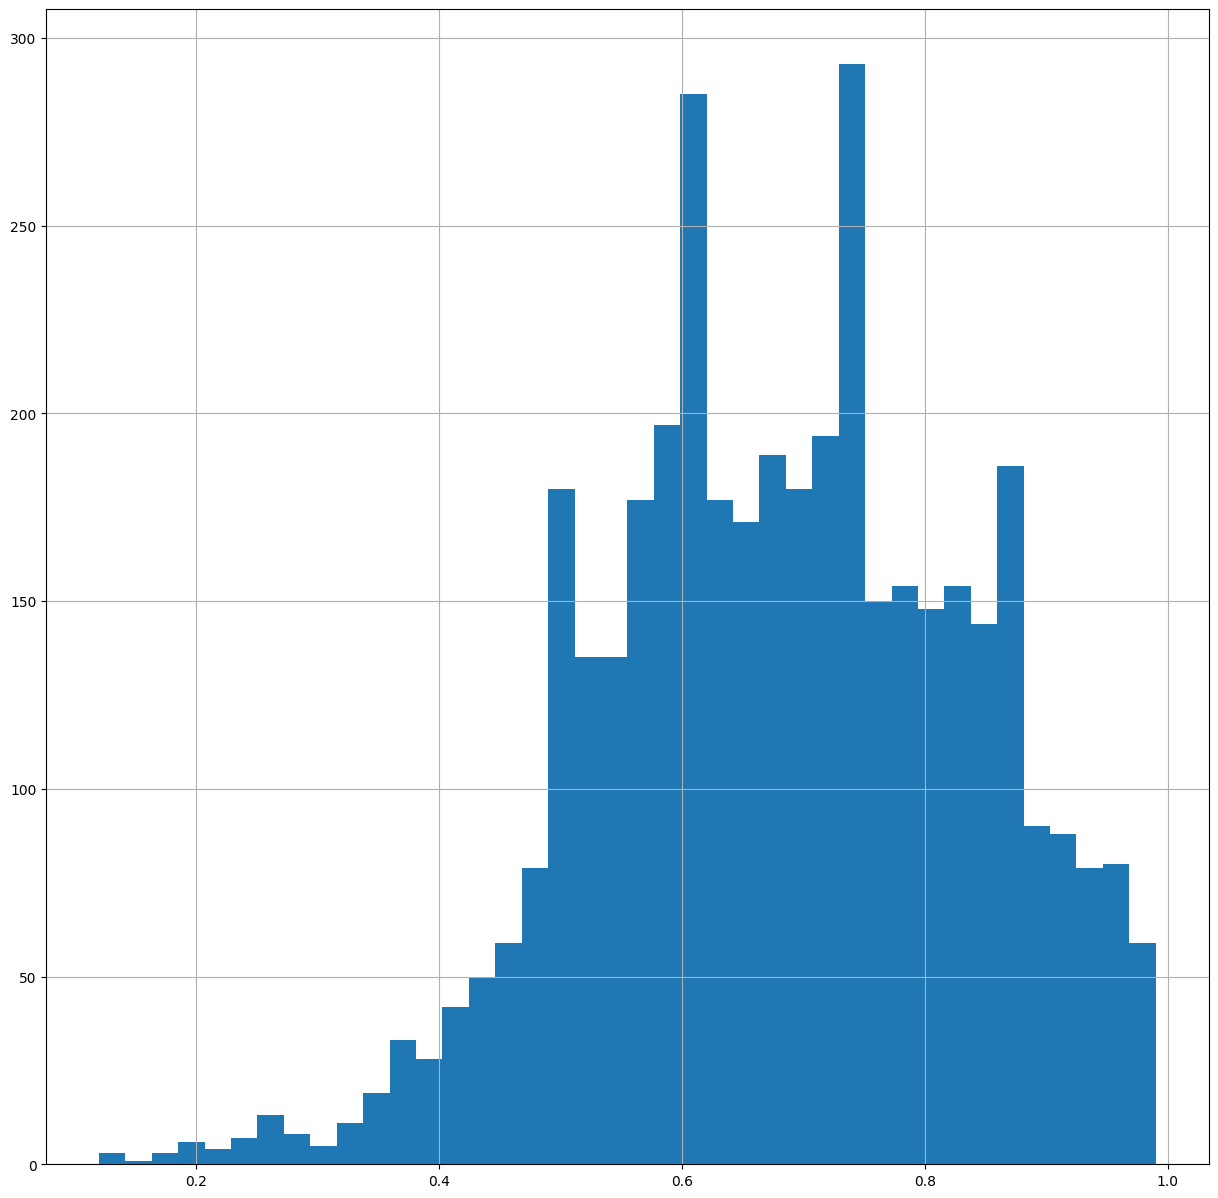

In [8]:
df['K'].hist(bins=40, figsize= (15, 15))
plt.show()

In [9]:
df['K'].median()

# De la misma forma, como los valores están sesgados a la derecha en este caso, 
# podríamos reemplazar los valores nulos por la mediana: 0.68.

np.float64(0.68)

In [10]:
df["K"] = df["K"].fillna(df["K"].median())

Variables categóricas

In [11]:
df['J'].head() 

# Vemos que estas columnas por más que sean categóricas, tienen valores numéricos, por lo que se las convierte a float.

0    UY
1    UY
2    UY
3    UY
4    UY
Name: J, dtype: object

In [12]:
df['J'].unique()

# Para entrenar los modelos de RandomForest y XGBoost, se hará one hot encoding sobre este campo luego de hacer el split de train, validation y test.
# Ya que RF y XGBoost no pueden trabajar con variables que no sean numéricas, y asignarles valores abitrarios, como 0 para UY, 
# 1 para MX, etc. jerarquiza los datos, lo cual no tiene sentido en este caso.

array(['UY', 'MX', 'US', 'ES', 'AR', 'CA', 'GB', 'UA', 'CL', 'CO', 'IT',
       'GT', 'PT', 'CH', 'TR', 'FR', 'KR', 'AU', 'BR'], dtype=object)

In [13]:
tabla = df.groupby("J").agg(
    tasa_fraude=("Fraude", "mean"),
    cantidad=("J", "count")
).sort_values("cantidad", ascending=False)
tabla

# Podemos ver que para ciertos paises, la tasa de fraude es altísima, por ejemplo UY. 
# Esto es muy importante porque es fácil para el modelo aprender que por ejemplo, si una transacción viene de UY sí o sí será fraude.
# Hice una prueba rápida eliminando comletamente este capo del modelo y no tuve mejoras, de hecho, el modelo se comportó peor,
# por lo que decido manetener el campo más allá de este comportamiento. 

,tasa_fraude,cantidad
J,,
AR,0.281488,9329
BR,0.248193,4428
MX,0.091293,2366
ES,0.939490,314
US,0.847826,230
UY,1.000000,180
CA,0.000000,12
GB,0.000000,8
GT,0.000000,2


Análisis de duplicados

In [14]:
duplicados = df[df.duplicated()] 
df.duplicated().sum()

# Vemos que hay un registro duplicado. Si bien es insignificante respecto al total de registros, se decide eliminarlo de todas formas. 

np.int64(1)

In [15]:
df[df.duplicated(keep=False)]

,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,Monto,Fraude
271,0,15,1739.0,0,0,0.0,0.0,0,0,US,...,0,3,1,0,5,0.0,0.0,-1.0,16.6,1
272,0,15,1739.0,0,0,0.0,0.0,0,0,US,...,0,3,1,0,5,0.0,0.0,-1.0,16.6,1


In [16]:
df = df.drop_duplicates()
duplicados = df[df.duplicated()] 

df.duplicated().sum()

np.int64(0)

Outliers

In [17]:
# No se sacarán los outliers, ya que pueden ser un indicador de fraude. 

Correlación

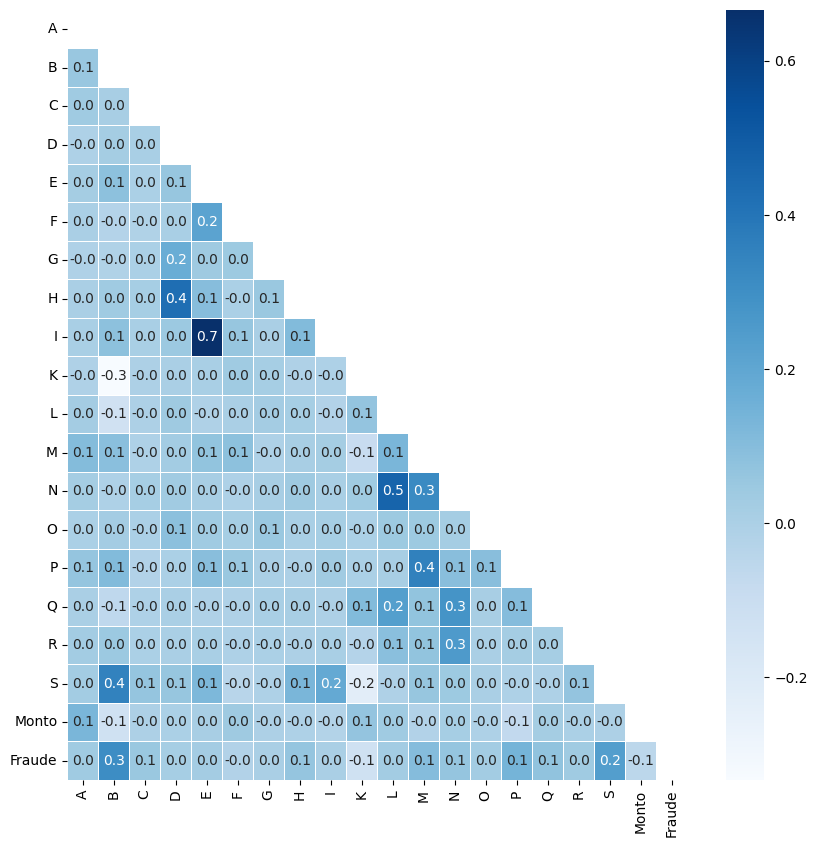

In [18]:
''' 
Diagrama de correlación y eliminar variables

Sí tiene sentido hacer el análisis, pero eliminar variables solo con criterio.
Matriz de correlación (heatmap): sirve para EDA, documentar el informe y ver dependencias entre predictores.
Eliminar por correlación: en Random Forest y XGBoost la multicolinealidad no es tan problemática como en regresión lineal; los árboles pueden usar variables correlacionadas sin romperse. Aun así:
Si dos variables están muy correlacionadas (p. ej. >0.95), puedes dejar una para reducir redundancia y algo de overfitting.
No elimines solo por “tener correlación”: prioriza importancia del modelo (feature importance) y sentido de negocio.
Recomendación: haz el heatmap de correlación entre variables numéricas (incluyendo las que convertiste a float). Usa la correlación como apoyo para decidir qué quitar, no como regla única; si en el informe explicas “revisé correlaciones y no eliminé variables porque el modelo las usa de forma no lineal”, también es válido.
'''

import seaborn as sns

numeric_data = df.select_dtypes(include=[np.number])

f,ax = plt.subplots(figsize=(10, 10))
mask = np.zeros_like(numeric_data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(numeric_data.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Blues",mask=mask)
plt.show() 

# Vemos que no hay variables extremadamente correlacionadas, por lo que se decide no eliminar variables bajo este criterio.

PCA

In [19]:

''' 
En tu caso, no es necesario y puede restar.
RF y XGBoost no asumen linealidad ni requieren escalado; trabajan bien con las variables originales.
Tienes pocas variables (~20) y muchas filas (16.880): no hay problema de dimensionalidad.
PCA es lineal y pierde interpretabilidad; en fraude suele interesar entender qué campos aportan.
Se usa PCA sobre todo con modelos lineales, SVM con kernel lineal, o cuando hay cientos de variables.
Recomendación: no apliques PCA para estos modelos. Si más adelante probaras regresión logística o SVM lineal, 
ahí sí podría tener sentido como experimento.
'''
# Como no es necesario para este tipo de modelos y además no tengo tantas variables, no se aplica.

' \nEn tu caso, no es necesario y puede restar.\nRF y XGBoost no asumen linealidad ni requieren escalado; trabajan bien con las variables originales.\nTienes pocas variables (~20) y muchas filas (16.880): no hay problema de dimensionalidad.\nPCA es lineal y pierde interpretabilidad; en fraude suele interesar entender qué campos aportan.\nSe usa PCA sobre todo con modelos lineales, SVM con kernel lineal, o cuando hay cientos de variables.\nRecomendación: no apliques PCA para estos modelos. Si más adelante probaras regresión logística o SVM lineal, \nahí sí podría tener sentido como experimento.\n'

Normalización y discretización

In [20]:

''' 
Normalización:
No necesaria para Random Forest ni XGBoost. Las divisiones de los árboles dependen de umbrales en una variable, no de la escala. 
Sí sería necesaria para SVM, KNN, redes neuronales, etc.

Discretización:
Los árboles ya hacen “cortes” en las variables continuas, así que no es obligatoria.
Puede ayudar en algunos casos: reducir ruido, mejorar interpretabilidad o estabilizar con variables muy asimétricas. 
Puedes probar como experimento (p. ej. bins para Monto o para una variable muy sesgada) y comparar métricas; 
no lo haría por defecto en el primer modelo.
Recomendación: para tu pipeline actual (RF + XGBoost): ni normalización ni discretización como paso estándar. 
Si quieres, prueba discretización solo en 1–2 variables y compara con el baseline.
'''
# No es necesario normalizar para este tipo de algoritmos.
# Si tengo tiempo de sobra, se verá cómo afecta la discretización en este caso.

' \nNormalización:\nNo necesaria para Random Forest ni XGBoost. Las divisiones de los árboles dependen de umbrales en una variable, no de la escala. \nSí sería necesaria para SVM, KNN, redes neuronales, etc.\n\nDiscretización:\nLos árboles ya hacen “cortes” en las variables continuas, así que no es obligatoria.\nPuede ayudar en algunos casos: reducir ruido, mejorar interpretabilidad o estabilizar con variables muy asimétricas. \nPuedes probar como experimento (p. ej. bins para Monto o para una variable muy sesgada) y comparar métricas; \nno lo haría por defecto en el primer modelo.\nRecomendación: para tu pipeline actual (RF + XGBoost): ni normalización ni discretización como paso estándar. \nSi quieres, prueba discretización solo en 1–2 variables y compara con el baseline.\n'

Oversampling


In [21]:
df["Fraude"].value_counts(normalize=True)

# Pensaba que iba a estar más desequilibrado el dataset, o sea, que el porcentaje de registros con fraude iban a ser mucho menor.


Fraude
0    0.72688
1    0.27312
Name: proportion, dtype: float64

In [22]:

''' 
Tu intuición va bien: con ~27% de fraudes no hace falta oversampling y es poco probable que mejore el rendimiento de forma clara.
Por qué con ~27% no suele ser necesario
Oversampling (SMOTE, etc.) tiene más sentido cuando el desbalance es muy fuerte: p. ej. &lt;1–5% de fraudes. Ahí el modelo puede “ignorar” la clase minoritaria.
Con ~27% vs ~73% la clase “fraude” ya está bien representada (miles de ejemplos). Random Forest y XGBoost suelen aprender bien ambas clases sin resampling.
Hacer oversampling con 27% puede:
No aportar mejora (o incluso empeorar)
Aumentar overfitting al repetir o sintetizar muchos fraudes
Alargar tiempo de entrenamiento sin beneficio claro
Qué sí suele ayudar en tu caso
Pesos de clase (sin tocar el balance de datos):
Random Forest: class_weight='balanced'
XGBoost: scale_pos_weight = (número de no fraude) / (número de fraude) (p. ej. 73/27 ≈ 2.7 si quieres penalizar más los fraudes no detectados)
Métricas: no mirar solo accuracy. Usar precision, recall, F1 (o F2 si priorizas recall) y AUC-PR (curva precision–recall), sobre todo si en producción te importa no perder fraudes.
Umbral de decisión: probar umbrales distintos (p. ej. 0.3, 0.4) en la probabilidad de fraude para subir recall a costa de algo de precision, según lo que pida el negocio.
Resumen
No es necesario oversampling con ~27% de fraudes; tu conclusión es correcta.
Mejor enfocarse en class_weight / scale_pos_weight, métricas adecuadas (recall, F1, AUC-PR) y ajuste del umbral. Si quieres, puedes probar oversampling como experimento y comparar con el baseline sin resampling; en muchos casos con 27% no se ve mejora.
'''
# Como se pensaba, al no estar tan desequilibrado el dataframe, no es necesario hacer sí o sí el oversampling. 
# Primero se decide a hacer una primer iteración y ver si efectivamente se necesita hacer un oversampling con el campo fraude.


" \nTu intuición va bien: con ~27% de fraudes no hace falta oversampling y es poco probable que mejore el rendimiento de forma clara.\nPor qué con ~27% no suele ser necesario\nOversampling (SMOTE, etc.) tiene más sentido cuando el desbalance es muy fuerte: p. ej. &lt;1–5% de fraudes. Ahí el modelo puede “ignorar” la clase minoritaria.\nCon ~27% vs ~73% la clase “fraude” ya está bien representada (miles de ejemplos). Random Forest y XGBoost suelen aprender bien ambas clases sin resampling.\nHacer oversampling con 27% puede:\nNo aportar mejora (o incluso empeorar)\nAumentar overfitting al repetir o sintetizar muchos fraudes\nAlargar tiempo de entrenamiento sin beneficio claro\nQué sí suele ayudar en tu caso\nPesos de clase (sin tocar el balance de datos):\nRandom Forest: class_weight='balanced'\nXGBoost: scale_pos_weight = (número de no fraude) / (número de fraude) (p. ej. 73/27 ≈ 2.7 si quieres penalizar más los fraudes no detectados)\nMétricas: no mirar solo accuracy. Usar precision, r

Separación del dataset en train, validation y test

In [23]:

from sklearn.model_selection import train_test_split

# Features y target
X = df.drop("Fraude", axis=1)
y = df["Fraude"]

# 70% train, 30% temporal (que será validation y test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Del 30% temporal: 50% validation y 50% test → 15% y 15% del total
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

n_total = len(df)
print("Train:      ", X_train.shape[0], f"({100 * X_train.shape[0] / n_total:.1f}%)")
print("Validation: ", X_val.shape[0], f"({100 * X_val.shape[0] / n_total:.1f}%)")
print("Test:       ", X_test.shape[0], f"({100 * X_test.shape[0] / n_total:.1f}%)")

Train:       11815 (70.0%)
Validation:  2532 (15.0%)
Test:        2532 (15.0%)


One-Hot Encoding de la columna J

In [24]:

# One-hot encoding de la columna J en cada conjunto
X_train = pd.get_dummies(X_train, columns=["J"], drop_first=False)
X_val = pd.get_dummies(X_val, columns=["J"], drop_first=False)
X_test = pd.get_dummies(X_test, columns=["J"], drop_first=False)

# Alinear columnas: val y test usan las mismas columnas que train (faltantes = 0)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

## Modelos utilizados

Criterio de negocio: maximizar ganancia.
- Transacción aprobada (legítima): ganancia 25% del monto.
- Fraude aprobado (no detectado): pérdida 100% del monto.
- Transacción rechazada (legítima): no se gana el 25% (costo de oportunidad -25%).
- Fraude rechazado: no se pierde ni se gana nada.

Orden de optimización:
1. Hiperparámetros → optimizar por PR-AUC (Precision-Recall AUC) en validación cruzada sobre train.
2. Umbral de decisión → con el mejor modelo, barrer umbrales en validación y elegir el que maximiza la ganancia.

In [25]:
def ganancia_empresa(
        y_true,       # El valor real
        pred_fraude,  # La predicción del modelo
        montos,       # Monto de la transacción
        ganancia_aprobada=0.25, 
        perdida_fraude_aprobado=1.0, 
        costo_rechazo_legitimo=0.25
    ):

    aprobamos = ~pred_fraude # Si se predice fraude, entonces NO aprobamos. Si no es fraude, aprobamos.

    tn = aprobamos & (y_true == 0)   # Transacciones aprobadas
    fn = aprobamos & (y_true == 1)   # Fraudes aprobados
    fp = ~aprobamos & (y_true == 0)  # Transacciones rechazadas

    ganancia = (
        ganancia_aprobada * np.sum(montos[tn])          # aprobamos Y es legítima
        - perdida_fraude_aprobado * np.sum(montos[fn])  # aprobamos Y era fraude
        - costo_rechazo_legitimo * np.sum(montos[fp])   # rechazamos Y era legítima
    )

    return ganancia

### Random Forest


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score
)

# 1. Definir modelo base

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# 2. Espacio de hiperparámetros optimizado

param_dist = {
    "n_estimators": [200, 400, 600, 800, 1000],     # Cantidad de árboles 
    "max_depth": [5, 10, 15, 20, 30, None],         # Profundidad máxima de cada árbol
    "min_samples_split": [2, 5, 10, 20],            # Cantidad mínima de samples para dividir un nodo
    "min_samples_leaf": [1, 2, 5, 10],              # Cantidad mínima de samples en una hoja.
    "max_features": ["sqrt", "log2", 0.5, 0.7],
    "class_weight": [
        "balanced",
        "balanced_subsample",
        {0:1, 1:3},
        {0:1, 1:5}
    ],
    "bootstrap": [True, False]
}

# 3. Random Search
# Usamos Random search para buscar la mejor configuración de hiperparámetros

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=15,  
    scoring="average_precision",  # PR-AUC, idealmente sería ganancia
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Entrenar
random_search.fit(X_train, y_train)

# Mejor modelo
rf_best = random_search.best_estimator_

print("\nMejores hiperparámetros:")
print(random_search.best_params_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits

Mejores hiperparámetros:
{'n_estimators': 800, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': None, 'class_weight': {0: 1, 1: 3}, 'bootstrap': True}


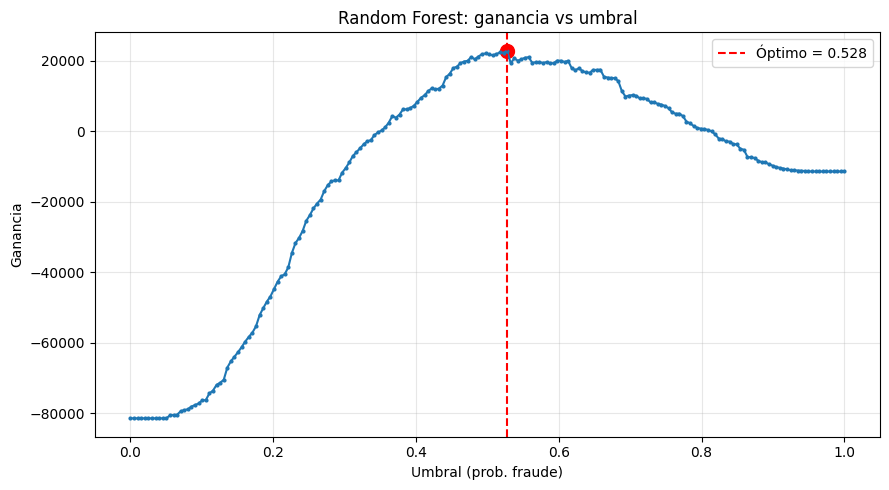

In [27]:
# 4. Obtener probabilidades

y_proba_val = rf_best.predict_proba(X_val)[:, 1]

# 5. Encontrar mejor umbral según GANANCIA
thresholds = np.linspace(0.0, 1.0, 200)

ganancias = []

best_gain = -np.inf
best_threshold = 0.5

for t in thresholds:
    y_pred = (y_proba_val >= t).astype(int)
    gain = ganancia_empresa(y_val, y_pred, X_val["Monto"])
    ganancias.append(gain)

    if gain > best_gain:
        best_gain = gain
        best_threshold = t
        
# Gráfico de Ganancia vs umbral

plt.figure(figsize=(9, 5))
plt.plot(thresholds, ganancias, marker=".", markersize=4)
plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    label=f"Óptimo = {best_threshold:.3f}"
)

plt.scatter(best_threshold, best_gain, color="red", s=100)
plt.xlabel("Umbral (prob. fraude)")
plt.ylabel("Ganancia")
plt.title("Random Forest: ganancia vs umbral")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# 6. Predicción final
y_proba_test = rf_best.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# 7. Métricas
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
pr_auc = average_precision_score(y_test, y_proba_test)
ganancia_test = ganancia_empresa(y_test, y_pred_test, X_test["Monto"])

# 8. Resultados
print("RESULTADOS RANDOM FOREST OPTIMIZADO")
print(f"Mejor umbral: {best_threshold:.4f}")
print(f"Ganancia: {ganancia_test:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

RESULTADOS RANDOM FOREST OPTIMIZADO
Mejor umbral: 0.5276
Ganancia: 9851.71
Precision: 0.5416
Recall: 0.6874
F1-score: 0.6059
PR-AUC: 0.6756


### XGBoost

In [29]:
from xgboost import XGBClassifier

# 1. Definir modelo base

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# 2. Espacio de hiperparámetros optimizado

param_dist = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [3, 5, 7, 9, 12],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 7],
    "gamma": [0, 0.1, 0.3, 0.5],
    "scale_pos_weight": [1, 3, 5, 10]
}

# 3. Random Search

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=15,
    scoring="average_precision",
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)
xgb_best = random_search_xgb.best_estimator_

print("Mejores hiperparámetros:")
print(random_search_xgb.best_params_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Mejores hiperparámetros:
{'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}


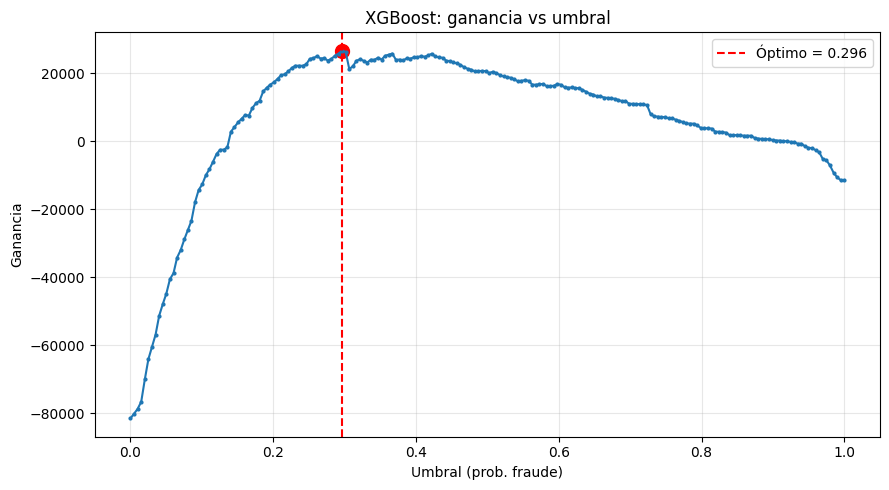

In [30]:
# 4. Obtener probabilidades

y_proba_val = xgb_best.predict_proba(X_val)[:,1]

# 5. Encontrar mejor umbral según GANANCIA

thresholds = np.linspace(0, 1, 200)
ganancias = [] 
best_gain = -np.inf
best_threshold = 0.5

for t in thresholds:
    y_pred = (y_proba_val >= t).astype(int)
    gain = ganancia_empresa(y_val, y_pred, X_val["Monto"])
    ganancias.append(gain) 
    if gain > best_gain:
        best_gain = gain
        best_threshold = t
        
# Gráfico de Ganancia vs umbral

plt.figure(figsize=(9, 5))

plt.plot(thresholds, ganancias, marker=".", markersize=4)

plt.axvline(
    best_threshold,
    color="red",
    linestyle="--",
    label=f"Óptimo = {best_threshold:.3f}"
)

plt.scatter(best_threshold, best_gain, color="red", s=100)

plt.xlabel("Umbral (prob. fraude)")
plt.ylabel("Ganancia")
plt.title("XGBoost: ganancia vs umbral")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# 6. Predicción final en TEST
y_proba_test = xgb_best.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= best_threshold).astype(int)

# 7. Métricas
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
pr_auc = average_precision_score(y_test, y_proba_test)
ganancia_test = ganancia_empresa(y_test, y_pred_test, X_test["Monto"])

# 8. Resultados

print("RESULTADOS XGBOOST")
print(f"Mejor threshold: {best_threshold:.4f}")
print(f"Ganancia: {ganancia_test:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")



RESULTADOS XGBOOST
Mejor threshold: 0.2965
Ganancia: 14631.06
Precision: 0.5500
Recall: 0.7004
F1-score: 0.6162
PR-AUC: 0.7067


## Evaluación

Las métricas que se obtuvieron son las siguientes:

- Recall de 0.7004: 70.04% de los fraude fueron correctamente identificadas. O sea, el modelo captura la mayoría de los casos fraudulentos.
- Precision de 0.55: sólo el 55% de los fraude son realmente fraudes. Podría mejorarse, ya que significa que hay un gran número de falsos positivos.
- F1-score de 0.6162 sugiere un equilibrio moderado entre recall y precisión.
- PR-AUC de 0.7067: es un valor bueno, porque se utilizó para el tuning porque es robusto en estos casos. Indica que el modelo tiene una capacidad razonable para diferenciar las clases.
- Ganancia de 26675.55. Se entrenó el modelo teniendo como objetivo esta métrica. No es tan sencillo entenderla como al resto, pero para esto vamos a plantear otros casos:


In [32]:
# Comparando con el modelo Random Forest:

# Random Forest: 9851.71
# XGBoost:       14631.06



In [33]:
# Comparando con un modelo que apruebe todas las transacciones:

ganancia_aprobar_todo = ganancia_empresa(
    y_test,
    pred_fraude=np.zeros_like(y_test, dtype=bool),
    montos=X_test["Monto"]
)

print(f"Ganancia_aprobar_todo: {ganancia_aprobar_todo:.2f}")
print(f"Ganancia modelo XGBoost: {ganancia_test:.2f}")

# Vemos que aprobar todo tiene pérdidas, hay una gran diferencia respecto al modelo de XGBoost.

Ganancia_aprobar_todo: -21449.24
Ganancia modelo XGBoost: 14631.06


In [34]:
# Comparando con un modelo ideal, que no tenga errores:
ganancia_ideal = ganancia_empresa(
    y_test,
    pred_fraude=y_test.astype(bool),
    montos=X_test["Monto"]
)

print(f"Ganancia ideal: {ganancia_ideal:.2f}")
print(f"Ganancia modelo: {ganancia_test:.2f}")

porcentaje = ganancia_test / ganancia_ideal * 100

print(f"El modelo alcanza el {porcentaje:.2f}% del máximo posible")

Ganancia ideal: 77720.63
Ganancia modelo: 14631.06
El modelo alcanza el 18.83% del máximo posible


Se puede ver que el modelo sólo alcanza el 18.83% de lo que alcanza un caso ideal. Sin duda hay mucho margen de mejora todavía.

## Conclusión

Como se dijo, el modelo sólo alcanza una fracción de lo que podría obtener de ganancia. Sin duda hay mucho margen de mejora.

Algunas cosas que creo que podrían optimizar los resultados, pero implicaría un desarrollo mucho más largo y el tiempo que tengo es acotado (máximo 15hs). Alguna de estas cosas son:
- Existe la chance de que en algunos campos, los valores nulos se hayan guardado como 0 en el origen de los datos, pero como no se tiene información sobre qué es cada campo, es dificil interpretar los valores, por lo que se decidió en no avanzar con este análisis, aunque es un posible punto de mejora a futuro.
- En el dataset que se me dió, no hay nulos salvo los de las columnas C y K, que fueron salvados usando la mediana. Pero en caso de usar el modelo con un dataset que tuviese nulos en otros campos, podría haber errores.
- Discretizar los valores podría traer mejoras en el desempeño del modelo. Al menos, se podría entrenar una vez con los valores discretizados y ver si aporta o no aporta una mejoría.
- El Oversampling no parece ser necesario para este caso, pero quizás hacer un class-weight podría servir, o al menos hacer pruebas como para ver si se obtiene alguna mejora.
- Análisis más extenso en la columna J: como se explicó, hay países con altísima tasa de fraude y gran cantidad de registros, principalmente UY. Esto podría crear reglas del modelo que no tienen mucho sentido en un modelo en producción. Es obvio que en la realidad el 100% de las trasnaccione en UY no son fraude, pero el modelo podría aprender que sí. Sin embargo, si bien probé reentrenar el modelo sin este campo, no tuve mejoras. Quizás se podría hacer otro tratamiento a este campo, como agrupar por países.
- En el tuning de los modelos, habría que cambiar scoring='average_precision' porque esto no optimiza la ganancia puntualmente. Se utilizó porque PR-AUC es bueno para datasets desbalanceados, y luego el threshold fue optimizado usando la función de ganancia del negocio. Pero no es lo óptimo para encontrar la ganancia máxima.


## Exportar el modelo

Para poder utilizar el modelo entrenado en otro lado, se exporta el modelo entrenado, el umbral y las columnas o campos del modelo. En el repositorio se encuentra otro notebook donde se importan estos valores y en una función llamada predecir_fraude se usa el modelo en un dataset reducido a modo de ejemplo.

In [ ]:
import joblib

joblib.dump(xgb_best, "modelo_xgboost_fraude.pkl")
joblib.dump(best_threshold, "threshold.pkl")
joblib.dump(X_train.columns.tolist(), "columnas_modelo.pkl")

['threshold.pkl']